# Creating a dask cluster (using dask-kubernetes)

In order to use Dask to perform complex and parallelized operations in Python we need to set up an environment within the cluster with a scheduler and workers. 

The easiest way to do this is by using the [dask_kubernetes](https://kubernetes.dask.org/en/latest/) library, which creates the environment using the native kubernetes API. It currently needs to be used within a Pod that contains permission to create and delete other pods, so let's do it.

## 1 The permissions
The dask_kubernetes lib uses the serviceaccount of the pod to make requests to the api, but as we do not specified any ServiceAccount to the pod, it should be using the "default" ServiceAccount. What we need to do is to provide this ServiceAccount the permission to control other pods and services.

Read about [Roles](https://kubernetes.io/docs/reference/access-authn-authz/rbac/) and [service accounts](https://kubernetes.io/docs/tasks/configure-pod-container/configure-service-account/).

We will:
1. Get the "default" ServiceAccount namespace
2. Create a Role to manage other pods
3. Bind the Role to "default" ServiceAccount at the same namespace

In [3]:
# First let's import the libs we will use in the next steps
import pykube
import yaml,json
# And make the pykube api object
api = pykube.HTTPClient(pykube.KubeConfig.from_file("k3s.yaml"))

In [8]:
# Now lets get the 'default' service account namespace information
sa = pykube.ServiceAccount.objects(api).get_by_name("default")
print("Name: "+sa.name,"\nNamespace: "+sa.namespace)

Name: default 
Namespace: default


In [12]:
# Now we will use pykube to create the dask_kubernetes Role provided by the documentation
# you can see it in the .yaml format here: https://kubernetes.dask.org/en/latest/#role-based-access-control-rbac
# I've alread parsed into a dict object

role = {
  "kind": "Role", 
  "apiVersion": "rbac.authorization.k8s.io/v1", 
  "metadata": {
    "name": "daskKubernetes"
  },
  "rules": [
    {
      "apiGroups": [
        ""
      ], 
      "verbs": [
        "get", 
        "list", 
        "watch", 
        "create", 
        "delete"
      ], 
      "resources": [
        "pods"
      ]
    }, 
    {
      "apiGroups": [
        ""
      ], 
      "verbs": [
        "get", 
        "list"
      ], 
      "resources": [
        "pods/log"
      ]
    }
  ], 
}

pykube.Role(api,role).create()

In [1]:
# Lets create the RoleBinding, to bind the role and the service account in the same namespace
roleBinding = {
  "apiVersion": "rbac.authorization.k8s.io/v1", 
  "metadata": {
    "namespace": "default", 
    "name": "daskKubernetes"
  },
  "roleRef": {
    "apiGroup": "rbac.authorization.k8s.io", 
    "kind": "Role", 
    "name": "daskKubernetes"
  }, 
  "kind": "RoleBinding", 
  "subjects": [
    {
      "kind": "ServiceAccount", 
      "namespace": "default", 
      "name": "default"
    }
  ]
}
pykube.RoleBinding(api,roleBinding).create()

## 2 Using the dask kubernetes
Now we can use the dask_kubernetes lib (already installed on the notebook) like de demo [here](https://kubernetes.dask.org/en/latest/).

In [1]:
from dask_kubernetes import KubeCluster

cluster = KubeCluster.from_yaml("daskKubernetes/worker.yaml")
cluster.scale(1)

distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:    tcp://10.42.0.10:34331
distributed.scheduler - INFO -   dashboard at:                     :8787


In [2]:
from dask.distributed import Client
client = Client(cluster)

distributed.scheduler - INFO - Receive client connection: Client-8a91467a-9d39-11ea-8024-d29c38a6fc12
distributed.core - INFO - Starting established connection


In [7]:
client

Client Scheduler: tcp://10.42.0.10:34331 Dashboard: http://10.42.0.10:8787/status,Cluster Workers: 1 Cores: 2 Memory: 4.00 GB


In [8]:
%%time
from time import sleep
from dask import delayed

def inc(x):
    sleep(1)
    return x + 1

def add(x, y):
    sleep(1)
    return x + y

x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x, y)

z.compute()

CPU times: user 161 ms, sys: 8.2 ms, total: 169 ms
Wall time: 2.03 s


5

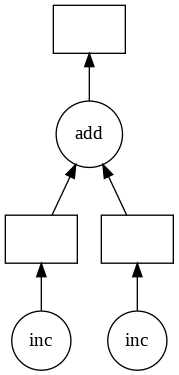

In [9]:
z.visualize()

In [10]:
client.close()

distributed.scheduler - INFO - Remove client Client-8a91467a-9d39-11ea-8024-d29c38a6fc12
distributed.scheduler - INFO - Remove client Client-8a91467a-9d39-11ea-8024-d29c38a6fc12
distributed.scheduler - INFO - Close client connection: Client-8a91467a-9d39-11ea-8024-d29c38a6fc12


In [11]:
cluster.close()

distributed.scheduler - INFO - Scheduler closing...
distributed.scheduler - INFO - Scheduler closing all comms
distributed.scheduler - INFO - Remove worker <Worker 'tcp://10.42.0.11:36285', name: 0, memory: 0, processing: 0>
distributed.core - INFO - Removing comms to tcp://10.42.0.11:36285
distributed.scheduler - INFO - Lost all workers
